# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [36]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

tf.config.set_visible_devices([], 'GPU')


# Exploratory Data Analysis

In [ ]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (150, 150)    # load at original size first
BATCH_SIZE = 128
LABEL_MODE = "categorical" # one‑hot labels straight away
AUTOTUNE = tf.data.AUTOTUNE

label_map={
    "broccoli":[1,0],
    "cauliflower":[0,1],
    "unknown":[0,0]
}
classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_dataset(data_dir, target_size=IMG_SIZE):
    X = []
    y = []

    for class_name in classes:
        class_dir = os.path.join(ROOT,data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        i=0
        lent=len(os.listdir(class_dir))

        for fname in os.listdir(class_dir):
            print("loading",i,"/",lent)
            fpath = os.path.join(class_dir, fname)

            try:
                img = load_img(fpath, target_size=target_size)
                img_array = img_to_array(img) / 255.0  # normalize
                X.append(img_array)
                y.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading {fpath}: {e}")
                continue

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return tf.data.Dataset.from_tensor_slices((X, y))

train_ds_pre = load_dataset("train")
val_ds_pre = load_dataset("validate")
test_ds_pre = load_dataset("test")
train_ds_pre=train_ds_pre.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_pre=val_ds_pre.cache().prefetch(buffer_size=AUTOTUNE)

,broccoli,cauliflower,unknown,splits total
test,1090,1068,344,2502
train,3949,3758,2149,9856
validate,1097,1064,344,2505
img total,6136,5890,2837,14863


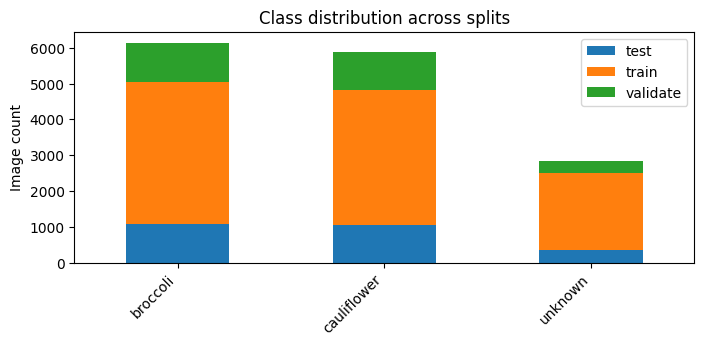

In [32]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

In [33]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

2025-07-13 23:49:17.904225: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 600x600 with 0 Axes>

# Data Preprocessing

In [34]:
TARGET_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom((0.3), 0.3),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

StagingError: in user code:

    File "/tmp/ipykernel_9136/1198547751.py", line 19, in None  *
        lambda x, y: (resize_and_rescale(x), y)
    File "/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/preprocessing/image_preprocessing/resizing.py", line 288, in compute_output_shape
        input_shape[0] = self.height

    IndexError: Exception encountered when calling Resizing.call().
    
    [1mlist assignment index out of range[0m
    
    Arguments received by Resizing.call():
      • args=('<KerasTensor shape=(), dtype=float32, sparse=False, ragged=False, name=keras_tensor_288>',)
      • kwargs={'training': 'True'}


2025-07-13 21:31:19.881701: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 34561536 bytes after encountering the first element of size 34561536 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-13 21:31:20.127532: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


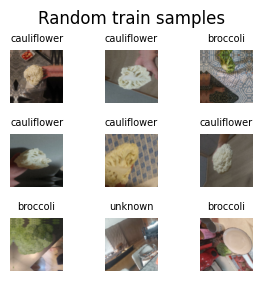

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [ ]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(2, ))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))


model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=Optimizer,
              metrics=['accuracy'])


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 43808)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     5,607,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,635,395 (21.50 MB)

 Trainable params: 5,635,395 (21.50 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
history = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data = val_ds
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights('model.weights.h5')
tf.keras.models.save_model(model,'model.keras')

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 58s 743ms/step - accuracy: 0.1709 - loss: 1.0478 - val_accuracy: 0.1373 - val_loss: 0.9535
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.1979 - loss: 0.9918 - val_accuracy: 0.1226 - val_loss: 0.9101
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 710ms/step - accuracy: 0.1716 - loss: 0.9541 - val_accuracy: 0.0687 - val_loss: 0.6968
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 54s 687ms/step - accuracy: 0.1773 - loss: 2.1035 - val_accuracy: 0.4379 - val_loss: 7.0587
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 53s 671ms/step - accuracy: 0.3991 - loss: 7.5635 - val_accuracy: 0.4379 - val_loss: 8.9631
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 710ms/step - accuracy: 0.3806 - loss: 7.1947 - val_accuracy: 0.1373 - val_loss: 1.0069
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.2181 - loss: 1.0670 - val_accuracy: 0.1373 - val_loss: 1.0000
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 711ms/step - accuracy: 0.2112 - loss: 1.0378 - val_accu

Invalid SOS parameters for sequential JPEG


Test loss: 2.2160770893096924
Test accuracy: 0.426858514547348


# Model Evalutation

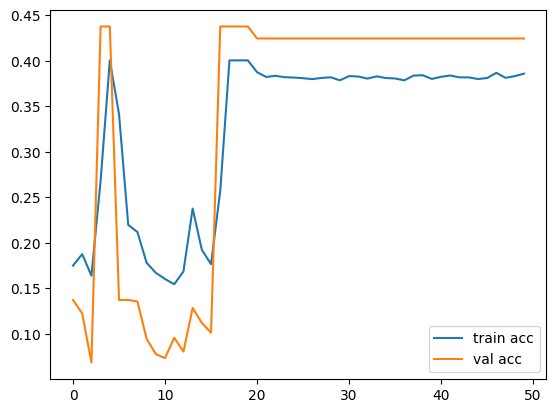

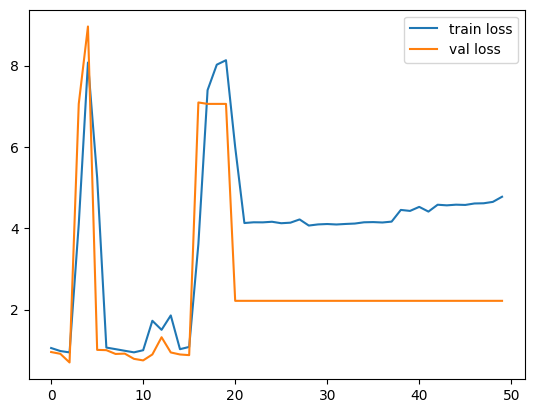

In [27]:

pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()